In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

In [2]:
try:
    import seaborn as sns
    sns.set()
    sns.set_style("whitegrid")
    sns.set_context("poster")
except ImportError as e:
    print("Cannot import seaborn.")
    print("Consider installing it for nice plot !")

mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Introduction


When particles collide inside the LHC, billions sub-particles are produced in all directions. The tracking detector measures the energy deposited by these sub-particle when hitting the detector material. So for each particles traversing the detector we get its impact points (10 points on average). 

The challenge is to reconstruct the particles trajectories from these 3D points.



## Load data

In [3]:
from dataset import load_hit_generator

In [4]:
data_path = "./public_data/training/"


In [5]:
event_generator = load_hit_generator(data_path)
event_id, event = next(event_generator)
data = event
event.head()

hit_id  volume_id  layer_id  module_id        x        y         z  ncells  \
0       1          0         0          0  606.259 -503.062  -206.233       2   
1       2          0         0          0 -521.955  581.235  -721.399       3   
2       3          0         0          0  601.154  489.960   515.355       2   
3       4          0         0          0  741.570  708.626  -205.964       4   
4       5          0         0          0 -799.681 -641.356  1030.120       3   

                                              pixels  
0           [[296, 0, 0.217322], [297, 0, 0.481904]]  
1  [[365, 0, 0.29192], [366, 0, 0.521079], [367, ...  
2             [[51, 0, 0.183442], [52, 0, 0.669276]]  
3  [[186, 0, 0.23186], [185, 0, 0.226563], [184, ...  
4  [[151, 0, 0.130911], [150, 0, 0.425835], [149,...

# Pre-Clustering : Dividing the 3D space  of one event

This step divides the dataset into N_pre_cluster regions. The pre-clustering is done with K-means

In [6]:
from sklearn.cluster import KMeans


In [7]:
data['r'] = np.hypot(data['x'], data['y'])


In [8]:
N_pre_cluster = 5  #Less than 5 pre-clusters will crash the agglomerative clustering

pre_labels = KMeans(n_clusters=N_pre_cluster).fit_predict(list(data[["r","z"]].values))


## Visualizing the divided space

In [9]:
from matplotlib import colors as mcolors # for colors

R_viz = 1000
colors = list(mcolors.CSS4_COLORS.keys())
from_each_reg = R_viz // N_pre_cluster #show only a portion of found regions
fig = plt.figure()

for i in range(N_pre_cluster):
    reg_i = np.random.choice(list(np.where(pre_labels==i)[0]), from_each_reg, replace=False)
    df_plot = data.iloc[reg_i]
    plt.plot(df_plot.z, df_plot.r, ".", c=colors[17+i])
plt.xlabel("Z")
plt.ylabel("R")
percentage = 100 * N_pre_cluster * from_each_reg / len(data.hit_id.values)
plt.title("Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage), fontsize=20)
plt.show()


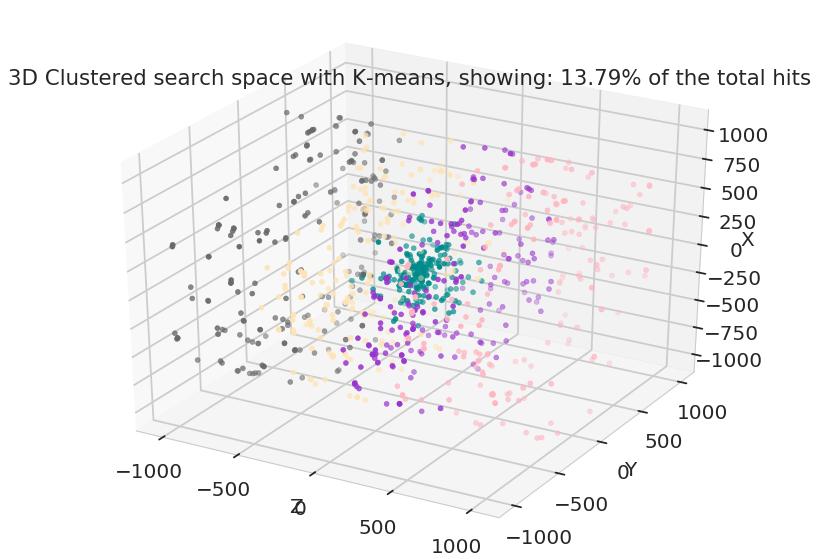

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_pre_cluster):
    reg_i = np.random.choice(list(np.where(pre_labels==i)[0]), from_each_reg, replace=False)
    df_plot = data.iloc[reg_i]
    ax.scatter(df_plot.z, df_plot.y, df_plot.x, ".", c=colors[17+i])

ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
percentage = 100 * N_pre_cluster * from_each_reg / len(data.hit_id.values)
plt.title("Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage))
plt.title("3D Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage))
plt.show()


## 3) Clustering one event

Actual pair-wise clustering using a cosine metric. This step produces tracks in each space region and assemble them into global labels.
Depending on the cut distance we choose, the reco tracks will vary. 
##### Smaller distances tend to reduce the size of recovered tracks.

In [11]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster


In [12]:
def cluster_hits2tracks(testX, max_d=0.0001, affinity="cosine"):
    """
    Simple PoC reconstruction algorithm
    """
    Z = linkage(testX, method="complete", metric=affinity)
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

## Tracker class

In [13]:
from tracking import BaseTracker

class HierachicalTracker(BaseTracker):
    def __init__(self, N_pre_cluster=5, eps=0.5, max_d=0.0001, affinity="cosine", verbose=1):
        super().__init__()
        self.N_pre_cluster = N_pre_cluster  #Less than 5 pre-clusters will crash the agglomerative clustering
        self.max_d = max_d
        self.affinity = affinity
        self.verbose = verbose
        
    def fit_generator(self, event_generator):
        pass

    def predict_generator(self, event_generator):
        sub_list = [self.predict_one_event(event_id, event) for event_id, event in event_generator]
        submission = pd.concat(sub_list)
        return submission
    
    def predict_one_event(self, event_id, event):
        if self.verbose:
            print(event_id)
            print(event.shape)
        event['r'] = np.hypot(event['x'], event['y'])
        pre_labels = KMeans(n_clusters=self.N_pre_cluster).fit_predict(list(event[["r","z"]].values))
        labels = np.zeros(len(event))
        regions = np.unique(pre_labels)
        n_regions = len(regions)
        
        for i in regions:
            if self.verbose:
                print( "Reconstructing region {}/{} ...".format(i+1, n_regions), flush=True)
            idx_clus = np.where( pre_labels==i )[0]
            clus = event.loc[ idx_clus, ["x","y","z"] ]
            labels[idx_clus] = cluster_hits2tracks( clus, max_d=self.max_d, affinity=self.affinity )
        tracks = pd.DataFrame(np.column_stack( (range(1,len(labels)+1),labels) ), columns=["hit_id","track_id"]).astype(int)
        tracks['event_id'] = event_id
        return tracks

        

## Visualize tracks

In [14]:
tracker = HierachicalTracker()
tracks = tracker.predict_one_event(event_id, event)
labels = tracks['track_id']

50
(7252, 10)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...


/home/estrade/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


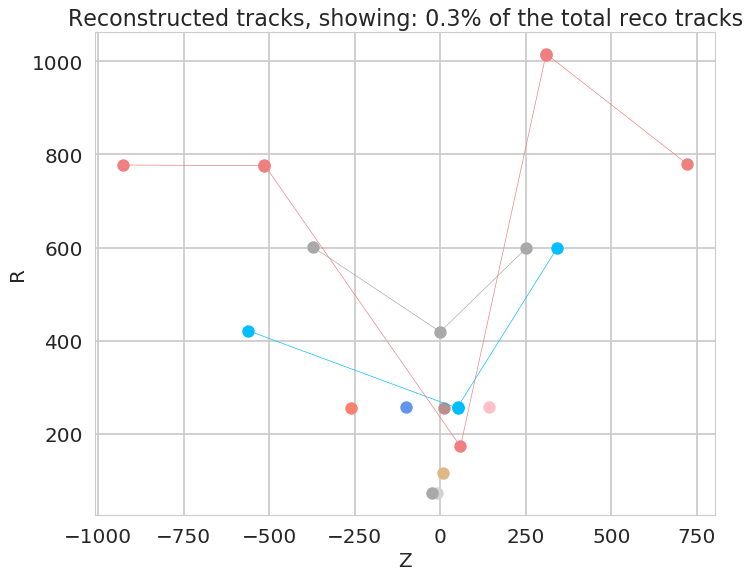

In [15]:
import random
T_viz=10
rand_tracks=random.sample(list(np.unique(labels)), T_viz)

fig = plt.figure(figsize=(10,8))
for i in rand_tracks:
    df_plot=data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    plt.plot(df_plot.z,df_plot.r,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.xlabel("Z")
plt.ylabel("R")
plt.title("Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
plt.show()


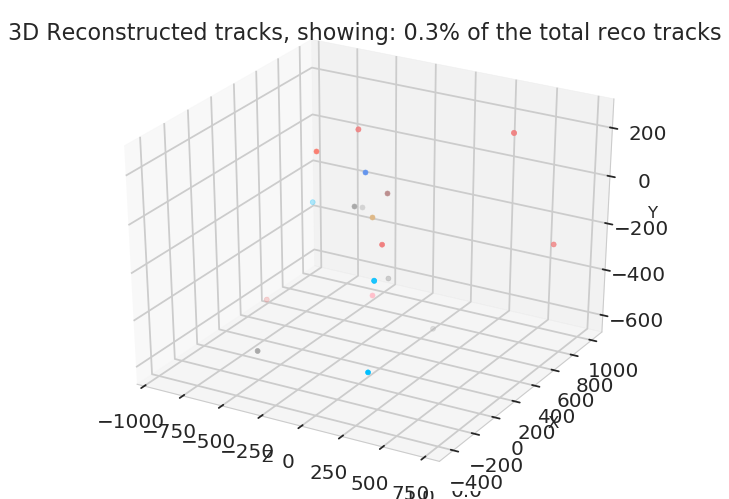

In [16]:
#3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
for i in rand_tracks:
    df_plot=data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    ax.scatter(df_plot.z,df_plot.x,df_plot.y,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.title("3D Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
ax.set_xlabel('Z',fontsize=15)
ax.set_ylabel('X',fontsize=15)
ax.set_zlabel('Y',fontsize=15)
plt.show()


## Tracking on the training set


In [17]:
tracker = HierachicalTracker()

In [18]:
from dataset import load_hit_generator
from itertools import islice

data_path = "./public_data/training/"
event_generator = load_hit_generator(data_path)
event_generator = (e for e in islice(event_generator, 5) )


** Warning : Next cell requires a lot of memory ** !!

In [19]:
# Warning : requires a lot of memory !!
submission = tracker.predict_generator(event_generator)

50
(7252, 9)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...
51
(9692, 9)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...
52
(7446, 9)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...
53
(4465, 9)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...
54
(6901, 9)
Reconstructing region 1/5 ...
Reconstructing region 2/5 ...
Reconstructing region 3/5 ...
Reconstructing region 4/5 ...
Reconstructing region 5/5 ...


## Scoring

In [20]:
solution = pd.read_csv("./public_data/training/solution.csv")

In [21]:
from score import compute_score

In [22]:
%%time
# Score on the full training set
# score_mean, score_std, n_purity_reco, n_purity_truth = compute_score(submission, solution)

# For only a slice of the training set
sol = solution.loc[solution['event_id'].isin(submission.event_id.unique())]
score_mean, score_std, n_purity_reco, n_purity_truth = compute_score(submission, sol)

CPU times: user 13.7 s, sys: 8 ms, total: 13.7 s
Wall time: 13.7 s


In [23]:
print('score mean:   {:f}'.format(score_mean))
print('score stddev: {:f}'.format(score_std))
print('purity_reco: {:d}'.format(n_purity_reco))
print('purity_truth: {:d}'.format(n_purity_truth))


score mean:   0.004070
score stddev: 0.003774
purity_reco: 678
purity_truth: 2021


In [24]:
print(len(tracks['track_id'].unique()), 'predicted particles')
print(len(solution['particle_id'].unique()), 'true particles')


2911 predicted particles
21866 true particles


# Writing submission file

## Tracking on validation data

In [ ]:
data_path = "./public_data/validation/"
event_generator = load_hit_generator(data_path)
submission = tracker.predict_generator(event_generator)

## Write the submission file

In [ ]:
submission.to_csv('./submission.csv', index=False, columns=["event_id","hit_id","track_id"])

Now just zip the file (**ONLY THE csv FILE ! NOT THE DIRECTORY**) and you can submit it to codalab.

The submission file has to be name "submission.csv"

The zip file name is not important for the pipeline.